In [1]:
#Tabular Manipulation
import pandas as pd
import numpy as np

#File management
import os
import csv

#Asynchronous Code
import asyncio #Run !pip install asyncio
import aiohttp #Run !pip install aiohttp

#Other
import requests
import warnings
import mysql.connector #run !pip install mysql-connector-python


warnings.simplefilter('ignore') #Turn off warnings

In [2]:
#Import and clean zctas
clean_zip = lambda zip: str(zip) if zip > 10000 else (f"0{zip}" if zip >= 1000 else f"00{zip}")

zctas = list(pd.read_excel("./ani_csv/ZIPCodetoZCTACrosswalk2021UDS.xlsx")["ZIP_CODE"]
         .map(clean_zip))

In [3]:
#Getting selected features
with open("./census_data/selected_features.txt", "r") as f:
    lines = f.readlines()

selected_features = [line.replace("\n", "").title() for line in lines if line != "\n" ]

In [4]:
#Getting selected features prefixes for division purposes
prefixes = []
curr_prefix = selected_features[0]
for feature in selected_features:
    if feature.startswith(curr_prefix):
        prefixes.append(curr_prefix)
    else:
        prefixes.append(feature)
        curr_prefix = feature

In [5]:
async def get_census_data_by_cat(zcta, cat):
    return pd.read_csv(f"./census_data/async_{cat}_chars/{zcta}.csv")

async def get_census_data_helper(zcta):
    lst = []
    for cat in ["demographic", "economic", "social"]:
        lst.append(await get_census_data_by_cat(zcta, cat))
    return lst

async def get_census_data(zcta):
    df_lst = await get_census_data_helper(zcta)
    return pd.concat([df for df in df_lst], axis=0)

async def isolate_selected_features(df):
    return df[df["Label"].isin(selected_features)].drop_duplicates(subset=["Label"])

async def add_prefix(df):
    new_df = df.copy()
    prefixes = []
    selected_features = list(df["Label"])
    curr_prefix = selected_features[0]
    for feature in selected_features:
        if feature.startswith(curr_prefix):
            prefixes.append(curr_prefix)
        else:
            prefixes.append(feature)
            curr_prefix = feature
    new_df["Prefix"] = prefixes
    return new_df

async def get_cleaned_unit_df(df):
    new_df = df.copy()
    raw_features = list(new_df[new_df["Percent"] == "(X)"]["Label"])
    labels = list(new_df["Label"])
    vals = []
    for i in range(len(labels)):
        if labels[i] in raw_features:
            vals.append(list(new_df[new_df['Label'] == labels[i]]['Estimate'])[0])
        elif labels[i] == list(new_df[new_df["Label"] == labels[i]]["Prefix"])[0]:
            vals.append(1)
        else:
            vals.append(float(list(new_df[new_df['Label'] == labels[i]]['Percent'])[0]) * 0.01)
            labels[i] = f"{labels[i]} As a Percent of {list(new_df[new_df['Label'] == labels[i]]['Prefix'])[0]}"
    return pd.DataFrame({"Label": labels, "Value": vals})

async def pivot_df_for_concat(df, zcta):
    new_df = df.copy()
    new_df["ZCTA"] = zcta
    pivoted_df = new_df.pivot(index="ZCTA", columns="Label", values="Value")
    return pivoted_df

In [6]:
async def clean_zcta(zcta):
    data_full = await get_census_data(zcta)
    data_filtered = await isolate_selected_features(data_full)
    data_with_prefix = await add_prefix(data_filtered)
    unit_df = await get_cleaned_unit_df(data_with_prefix)
    pivot_df = await pivot_df_for_concat(unit_df, zcta)
    return pivot_df

In [7]:
start_df = await clean_zcta("00601")

In [8]:
len(zctas)

41091

In [9]:
len(os.listdir("./census_data/async_demographic_chars/"))

32923

In [ ]:
failed = 0
succeeded = 0
for i in range(len(zctas)):
    zcta = zctas[i]
    if (i % 329 == 0):
        print(f"{i / 329}% Complete")
    try:
        start_df = pd.concat([start_df, await clean_zcta(zcta)], axis=0)
        succeeded = succeeded + 1
    except:
        failed = failed + 1

0.0% Complete
1.0% Complete
2.0% Complete
3.0% Complete
4.0% Complete
5.0% Complete
6.0% Complete
7.0% Complete
8.0% Complete
9.0% Complete
10.0% Complete
11.0% Complete
12.0% Complete
13.0% Complete
14.0% Complete
15.0% Complete
16.0% Complete
17.0% Complete
18.0% Complete
19.0% Complete
20.0% Complete
21.0% Complete
22.0% Complete
23.0% Complete
24.0% Complete
25.0% Complete
26.0% Complete
27.0% Complete
28.0% Complete
29.0% Complete
30.0% Complete
31.0% Complete
32.0% Complete
33.0% Complete
34.0% Complete
35.0% Complete
36.0% Complete
37.0% Complete
38.0% Complete
39.0% Complete
40.0% Complete
41.0% Complete
42.0% Complete
43.0% Complete
44.0% Complete
45.0% Complete
46.0% Complete
47.0% Complete
48.0% Complete
49.0% Complete
50.0% Complete
51.0% Complete
52.0% Complete
53.0% Complete
54.0% Complete
55.0% Complete
56.0% Complete
57.0% Complete
58.0% Complete
59.0% Complete
60.0% Complete
61.0% Complete
62.0% Complete
63.0% Complete
64.0% Complete
65.0% Complete
66.0% Complete
67.0%

In [12]:
feature_df_uncleaned = start_df

In [21]:
feature_df_uncleaned[feature_df_uncleaned["Estimate Computers And Internet Use Total Households With A Broadband Internet Subscription As a Percent of Estimate Computers And Internet Use Total Households"].isna()

Label,Estimate Computers And Internet Use Total Households,Estimate Computers And Internet Use Total Households With A Broadband Internet Subscription As a Percent of Estimate Computers And Internet Use Total Households,Estimate Computers And Internet Use Total Households With A Computer As a Percent of Estimate Computers And Internet Use Total Households,Estimate Disability Status Of The Civilian Noninstitutionalized Population 18 To 64 Years,Estimate Disability Status Of The Civilian Noninstitutionalized Population 18 To 64 Years With A Disability As a Percent of Estimate Disability Status Of The Civilian Noninstitutionalized Population 18 To 64 Years,Estimate Disability Status Of The Civilian Noninstitutionalized Population Total Civilian Noninstitutionalized Population,Estimate Disability Status Of The Civilian Noninstitutionalized Population Total Civilian Noninstitutionalized Population With A Disability As a Percent of Estimate Disability Status Of The Civilian Noninstitutionalized Population Total Civilian Noninstitutionalized Population,Estimate Disability Status Of The Civilian Noninstitutionalized Population Under 18 Years,Estimate Disability Status Of The Civilian Noninstitutionalized Population Under 18 Years With A Disability As a Percent of Estimate Disability Status Of The Civilian Noninstitutionalized Population Under 18 Years,Estimate Educational Attainment Population 25 Years And Over,...,Estimate Sex And Age Total Population 75 To 84 Years As a Percent of Estimate Sex And Age Total Population,Estimate Sex And Age Total Population Male As a Percent of Estimate Sex And Age Total Population,Estimate Sex And Age Total Population Median Age (Years),Estimate Sex And Age Total Population Under 5 Years As a Percent of Estimate Sex And Age Total Population,Estimate U.S. Citizenship Status Foreign-Born Population,Estimate U.S. Citizenship Status Foreign-Born Population Naturalized U.S. Citizen As a Percent of Estimate U.S. Citizenship Status Foreign-Born Population,Estimate Veteran Status Civilian Population 18 Years And Over,Estimate Veteran Status Civilian Population 18 Years And Over Civilian Veterans As a Percent of Estimate Veteran Status Civilian Population 18 Years And Over,Estimate Households By Type Total Households Average Family Size,Estimate Households By Type Total Households Average Household Size
ZCTA,,,,,,,,,,,,,,,,,,,,,
00601,1,NaN,NaN,1,NaN,1,NaN,1,NaN,1,...,0.064,0.493,43.7,0.038,1,NaN,1,NaN,NaN,NaN
00601,1,NaN,NaN,1,NaN,1,NaN,1,NaN,1,...,0.064,0.493,43.7,0.038,1,NaN,1,NaN,NaN,NaN
00602,1,NaN,NaN,1,NaN,1,NaN,1,NaN,1,...,0.062,0.491,44.4,0.033,1,NaN,1,NaN,NaN,NaN
00603,1,NaN,NaN,1,NaN,1,NaN,1,NaN,1,...,0.077,0.485,44.1,0.038,1,NaN,1,NaN,NaN,NaN
00606,1,NaN,NaN,1,NaN,1,NaN,1,NaN,1,...,0.047,0.49,44.9,0.039,1,NaN,1,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
00979,1,NaN,NaN,1,NaN,1,NaN,1,NaN,1,...,0.071,0.502,49.8,0.019,1,NaN,1,NaN,NaN,NaN
00982,1,NaN,NaN,1,NaN,1,NaN,1,NaN,1,...,0.103,0.435,44.7,0.041,1,NaN,1,NaN,NaN,NaN
00983,1,NaN,NaN,1,NaN,1,NaN,1,NaN,1,...,0.09,0.447,41.7,0.048,1,NaN,1,NaN,NaN,NaN


In [55]:
#Getting States per ZCTA
zcta_df = pd.read_excel("./ani_csv/ZIPCodetoZCTACrosswalk2021UDS.xlsx")
zcta_df

,ZIP_CODE,PO_NAME,STATE,ZIP_TYPE,ZCTA,zip_join_type
0,501,Holtsville,NY,Post Office or large volume customer,11742.0,Spatial join to ZCTA
1,544,Holtsville,NY,Post Office or large volume customer,11742.0,Spatial join to ZCTA
2,601,Adjuntas,PR,Zip Code Area,601.0,Zip matches ZCTA
3,602,Aguada,PR,Zip Code Area,602.0,Zip matches ZCTA
4,603,Aguadilla,PR,Zip Code Area,603.0,Zip matches ZCTA
...,...,...,...,...,...,...
41086,99926,Metlakatla,AK,Zip Code Area,99926.0,Zip matches ZCTA
41087,99927,Point Baker,AK,Zip Code Area,99927.0,Zip matches ZCTA
41088,99928,Ward Cove,AK,Post Office or large volume customer,99901.0,Spatial join to ZCTA
41089,99929,Wrangell,AK,Zip Code Area,99929.0,Zip matches ZCTA


In [56]:
#Realizing the merging was done incorrectly, so redoing for ZCTAs not in feature_df_uncleaned.index()
zcta_df = zcta_df[["STATE", "ZCTA", "ZIP_CODE"]]
zcta_df = zcta_df[~zcta_df["ZCTA"].isna()]
zcta_df["ZCTA"] = zcta_df["ZCTA"].astype(int)
zcta_df["ZIP_CODE"] = zcta_df["ZIP_CODE"].map(clean_zip)
zcta_df

,STATE,ZCTA,ZIP_CODE
0,NY,11742,00501
1,NY,11742,00544
2,PR,601,00601
3,PR,602,00602
4,PR,603,00603
...,...,...,...
41086,AK,99926,99926
41087,AK,99927,99927
41088,AK,99901,99928
41089,AK,99929,99929


In [57]:
zcta_df["ZCTA"] = zcta_df["ZCTA"].map(clean_zip)

In [62]:
true_zctas = list(zcta_df[zcta_df["ZCTA"] != zcta_df["ZIP_CODE"]]["ZCTA"])
len(true_zctas)

7944

In [ ]:
for i in range(len(true_zctas)):
    zcta = true_zctas[i]
    if (i % 79 == 0):
        print(f"{i / 79}% Complete")
    try:
        feature_df_uncleaned = pd.concat([feature_df_uncleaned, await clean_zcta(zcta)], axis=0)
        succeeded = succeeded + 1
    except:
        failed = failed + 1

0.0% Complete
1.0% Complete
2.0% Complete
3.0% Complete
4.0% Complete
5.0% Complete
6.0% Complete
7.0% Complete
8.0% Complete
9.0% Complete
10.0% Complete
11.0% Complete
12.0% Complete
13.0% Complete
14.0% Complete
15.0% Complete
16.0% Complete
17.0% Complete
18.0% Complete
19.0% Complete
20.0% Complete
21.0% Complete
22.0% Complete
23.0% Complete
24.0% Complete
25.0% Complete
26.0% Complete
27.0% Complete
28.0% Complete
29.0% Complete
30.0% Complete
31.0% Complete
32.0% Complete
33.0% Complete
34.0% Complete
35.0% Complete
36.0% Complete
37.0% Complete
38.0% Complete
39.0% Complete
40.0% Complete
41.0% Complete
42.0% Complete
43.0% Complete
44.0% Complete
45.0% Complete
46.0% Complete
47.0% Complete
48.0% Complete
49.0% Complete
50.0% Complete
51.0% Complete
52.0% Complete
53.0% Complete
54.0% Complete
55.0% Complete
56.0% Complete
57.0% Complete
58.0% Complete
59.0% Complete
60.0% Complete
61.0% Complete
62.0% Complete
63.0% Complete
64.0% Complete
65.0% Complete
66.0% Complete
67.0%

In [65]:
feature_df_uncleaned

Label,Estimate Computers And Internet Use Total Households,Estimate Computers And Internet Use Total Households With A Broadband Internet Subscription As a Percent of Estimate Computers And Internet Use Total Households,Estimate Computers And Internet Use Total Households With A Computer As a Percent of Estimate Computers And Internet Use Total Households,Estimate Disability Status Of The Civilian Noninstitutionalized Population 18 To 64 Years,Estimate Disability Status Of The Civilian Noninstitutionalized Population 18 To 64 Years With A Disability As a Percent of Estimate Disability Status Of The Civilian Noninstitutionalized Population 18 To 64 Years,Estimate Disability Status Of The Civilian Noninstitutionalized Population Total Civilian Noninstitutionalized Population,Estimate Disability Status Of The Civilian Noninstitutionalized Population Total Civilian Noninstitutionalized Population With A Disability As a Percent of Estimate Disability Status Of The Civilian Noninstitutionalized Population Total Civilian Noninstitutionalized Population,Estimate Disability Status Of The Civilian Noninstitutionalized Population Under 18 Years,Estimate Disability Status Of The Civilian Noninstitutionalized Population Under 18 Years With A Disability As a Percent of Estimate Disability Status Of The Civilian Noninstitutionalized Population Under 18 Years,Estimate Educational Attainment Population 25 Years And Over,...,Estimate Sex And Age Total Population 75 To 84 Years As a Percent of Estimate Sex And Age Total Population,Estimate Sex And Age Total Population Male As a Percent of Estimate Sex And Age Total Population,Estimate Sex And Age Total Population Median Age (Years),Estimate Sex And Age Total Population Under 5 Years As a Percent of Estimate Sex And Age Total Population,Estimate U.S. Citizenship Status Foreign-Born Population,Estimate U.S. Citizenship Status Foreign-Born Population Naturalized U.S. Citizen As a Percent of Estimate U.S. Citizenship Status Foreign-Born Population,Estimate Veteran Status Civilian Population 18 Years And Over,Estimate Veteran Status Civilian Population 18 Years And Over Civilian Veterans As a Percent of Estimate Veteran Status Civilian Population 18 Years And Over,Estimate Households By Type Total Households Average Family Size,Estimate Households By Type Total Households Average Household Size
ZCTA,,,,,,,,,,,,,,,,,,,,,
00601,1,NaN,NaN,1,NaN,1,NaN,1,NaN,1,...,0.064,0.493,43.7,0.038,1,NaN,1,NaN,NaN,NaN
00601,1,NaN,NaN,1,NaN,1,NaN,1,NaN,1,...,0.064,0.493,43.7,0.038,1,NaN,1,NaN,NaN,NaN
00602,1,NaN,NaN,1,NaN,1,NaN,1,NaN,1,...,0.062,0.491,44.4,0.033,1,NaN,1,NaN,NaN,NaN
00603,1,NaN,NaN,1,NaN,1,NaN,1,NaN,1,...,0.077,0.485,44.1,0.038,1,NaN,1,NaN,NaN,NaN
00606,1,NaN,NaN,1,NaN,1,NaN,1,NaN,1,...,0.047,0.49,44.9,0.039,1,NaN,1,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99801,1,0.92,0.961,1,0.092,1,0.115,1,0.047,1,...,0.034,0.51,38.7,0.055,1,0.665,1,0.076,3.19,2.48
99801,1,0.92,0.961,1,0.092,1,0.115,1,0.047,1,...,0.034,0.51,38.7,0.055,1,0.665,1,0.076,3.19,2.48
99801,1,0.92,0.961,1,0.092,1,0.115,1,0.047,1,...,0.034,0.51,38.7,0.055,1,0.665,1,0.076,3.19,2.48


In [77]:
print(f'The success rate to get info for each ZCTA was {1 - failed/succeeded}')

The success rate to get info for each ZCTA was 0.7992506795308176


In [76]:
zcta_df

,STATE,ZCTA,ZIP_CODE
0,NY,11742,00501
1,NY,11742,00544
2,PR,00601,00601
3,PR,00602,00602
4,PR,00603,00603
...,...,...,...
41086,AK,99926,99926
41087,AK,99927,99927
41088,AK,99901,99928
41089,AK,99929,99929


In [88]:
from sklearn.preprocessing import OneHotEncoder

ohe = OneHotEncoder()

In [93]:
os.path.getsize("./census_data/feature_df_uncleaned.csv")

35048283

In [94]:
pd.read_csv("./census_data/feature_df_uncleaned.csv")

,ZCTA,Estimate Computers And Internet Use Total Households,Estimate Computers And Internet Use Total Households With A Broadband Internet Subscription As a Percent of Estimate Computers And Internet Use Total Households,Estimate Computers And Internet Use Total Households With A Computer As a Percent of Estimate Computers And Internet Use Total Households,Estimate Disability Status Of The Civilian Noninstitutionalized Population 18 To 64 Years,Estimate Disability Status Of The Civilian Noninstitutionalized Population 18 To 64 Years With A Disability As a Percent of Estimate Disability Status Of The Civilian Noninstitutionalized Population 18 To 64 Years,Estimate Disability Status Of The Civilian Noninstitutionalized Population Total Civilian Noninstitutionalized Population,Estimate Disability Status Of The Civilian Noninstitutionalized Population Total Civilian Noninstitutionalized Population With A Disability As a Percent of Estimate Disability Status Of The Civilian Noninstitutionalized Population Total Civilian Noninstitutionalized Population,Estimate Disability Status Of The Civilian Noninstitutionalized Population Under 18 Years,Estimate Disability Status Of The Civilian Noninstitutionalized Population Under 18 Years With A Disability As a Percent of Estimate Disability Status Of The Civilian Noninstitutionalized Population Under 18 Years,...,Estimate Sex And Age Total Population 75 To 84 Years As a Percent of Estimate Sex And Age Total Population,Estimate Sex And Age Total Population Male As a Percent of Estimate Sex And Age Total Population,Estimate Sex And Age Total Population Median Age (Years),Estimate Sex And Age Total Population Under 5 Years As a Percent of Estimate Sex And Age Total Population,Estimate U.S. Citizenship Status Foreign-Born Population,Estimate U.S. Citizenship Status Foreign-Born Population Naturalized U.S. Citizen As a Percent of Estimate U.S. Citizenship Status Foreign-Born Population,Estimate Veteran Status Civilian Population 18 Years And Over,Estimate Veteran Status Civilian Population 18 Years And Over Civilian Veterans As a Percent of Estimate Veteran Status Civilian Population 18 Years And Over,Estimate Households By Type Total Households Average Family Size,Estimate Households By Type Total Households Average Household Size
0,601,1,NaN,NaN,1,NaN,1,NaN,1,NaN,...,0.064,0.493,43.7,0.038,1,NaN,1,NaN,NaN,NaN
1,601,1,NaN,NaN,1,NaN,1,NaN,1,NaN,...,0.064,0.493,43.7,0.038,1,NaN,1,NaN,NaN,NaN
2,602,1,NaN,NaN,1,NaN,1,NaN,1,NaN,...,0.062,0.491,44.4,0.033,1,NaN,1,NaN,NaN,NaN
3,603,1,NaN,NaN,1,NaN,1,NaN,1,NaN,...,0.077,0.485,44.1,0.038,1,NaN,1,NaN,NaN,NaN
4,606,1,NaN,NaN,1,NaN,1,NaN,1,NaN,...,0.047,0.490,44.9,0.039,1,NaN,1,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
40833,99801,1,0.920,0.961,1,0.092,1,0.115,1,0.047,...,0.034,0.510,38.7,0.055,1,0.665,1,0.076,3.19,2.48
40834,99801,1,0.920,0.961,1,0.092,1,0.115,1,0.047,...,0.034,0.510,38.7,0.055,1,0.665,1,0.076,3.19,2.48
40835,99801,1,0.920,0.961,1,0.092,1,0.115,1,0.047,...,0.034,0.510,38.7,0.055,1,0.665,1,0.076,3.19,2.48
40836,99901,1,0.876,0.937,1,0.117,1,0.150,1,0.047,...,0.038,0.516,40.3,0.051,1,0.688,1,0.096,2.99,2.50


<h2>One Hot Encoding the States as Features</h2>

In [95]:
zcta_df.set_index("ZCTA", inplace=True)
zcta_df

,STATE,ZIP_CODE
ZCTA,,
11742,NY,00501
11742,NY,00544
00601,PR,00601
00602,PR,00602
00603,PR,00603
...,...,...
99926,AK,99926
99927,AK,99927
99901,AK,99928


In [96]:
#Fit the One Hot Encoder for State Code
ohe.fit(zcta_df[["STATE"]])
ohe

OneHotEncoder()

In [97]:
state_code_ohe_data = ohe.transform(zcta_df[["STATE"]]).toarray()
zcta_with_ohe_state = zcta_df.join(pd.DataFrame(state_code_ohe_data, columns=ohe.get_feature_names_out(), index=zcta_df.index))
zcta_with_ohe_state = zcta_with_ohe_state.drop(columns=["STATE"])
zcta_with_ohe_state

,ZIP_CODE,STATE_AK,STATE_AL,STATE_AR,STATE_AS,STATE_AZ,STATE_CA,STATE_CO,STATE_CT,STATE_DC,...,STATE_TN,STATE_TX,STATE_UT,STATE_VA,STATE_VI,STATE_VT,STATE_WA,STATE_WI,STATE_WV,STATE_WY
ZCTA,,,,,,,,,,,,,,,,,,,,,
00601,00601,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
00602,00602,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
00603,00603,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
00603,00603,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
00603,00603,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99923,99923,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
99925,99925,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
99926,99926,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [98]:
zcta_with_ohe_state = zcta_with_ohe_state.drop(columns=["ZIP_CODE"])
zcta_with_ohe_state

,STATE_AK,STATE_AL,STATE_AR,STATE_AS,STATE_AZ,STATE_CA,STATE_CO,STATE_CT,STATE_DC,STATE_DE,...,STATE_TN,STATE_TX,STATE_UT,STATE_VA,STATE_VI,STATE_VT,STATE_WA,STATE_WI,STATE_WV,STATE_WY
ZCTA,,,,,,,,,,,,,,,,,,,,,
00601,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
00602,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
00603,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
00603,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
00603,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99923,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
99925,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
99926,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


<h2>Dropping Duplicates in the Uncleaned Design Matrix, Cleaning, and Merging with One Hot Encoded Data</h2>

In [99]:
uncleaned_design_matrix = pd.read_csv("./census_data/feature_df_uncleaned.csv")
uncleaned_design_matrix

,ZCTA,Estimate Computers And Internet Use Total Households,Estimate Computers And Internet Use Total Households With A Broadband Internet Subscription As a Percent of Estimate Computers And Internet Use Total Households,Estimate Computers And Internet Use Total Households With A Computer As a Percent of Estimate Computers And Internet Use Total Households,Estimate Disability Status Of The Civilian Noninstitutionalized Population 18 To 64 Years,Estimate Disability Status Of The Civilian Noninstitutionalized Population 18 To 64 Years With A Disability As a Percent of Estimate Disability Status Of The Civilian Noninstitutionalized Population 18 To 64 Years,Estimate Disability Status Of The Civilian Noninstitutionalized Population Total Civilian Noninstitutionalized Population,Estimate Disability Status Of The Civilian Noninstitutionalized Population Total Civilian Noninstitutionalized Population With A Disability As a Percent of Estimate Disability Status Of The Civilian Noninstitutionalized Population Total Civilian Noninstitutionalized Population,Estimate Disability Status Of The Civilian Noninstitutionalized Population Under 18 Years,Estimate Disability Status Of The Civilian Noninstitutionalized Population Under 18 Years With A Disability As a Percent of Estimate Disability Status Of The Civilian Noninstitutionalized Population Under 18 Years,...,Estimate Sex And Age Total Population 75 To 84 Years As a Percent of Estimate Sex And Age Total Population,Estimate Sex And Age Total Population Male As a Percent of Estimate Sex And Age Total Population,Estimate Sex And Age Total Population Median Age (Years),Estimate Sex And Age Total Population Under 5 Years As a Percent of Estimate Sex And Age Total Population,Estimate U.S. Citizenship Status Foreign-Born Population,Estimate U.S. Citizenship Status Foreign-Born Population Naturalized U.S. Citizen As a Percent of Estimate U.S. Citizenship Status Foreign-Born Population,Estimate Veteran Status Civilian Population 18 Years And Over,Estimate Veteran Status Civilian Population 18 Years And Over Civilian Veterans As a Percent of Estimate Veteran Status Civilian Population 18 Years And Over,Estimate Households By Type Total Households Average Family Size,Estimate Households By Type Total Households Average Household Size
0,601,1,NaN,NaN,1,NaN,1,NaN,1,NaN,...,0.064,0.493,43.7,0.038,1,NaN,1,NaN,NaN,NaN
1,601,1,NaN,NaN,1,NaN,1,NaN,1,NaN,...,0.064,0.493,43.7,0.038,1,NaN,1,NaN,NaN,NaN
2,602,1,NaN,NaN,1,NaN,1,NaN,1,NaN,...,0.062,0.491,44.4,0.033,1,NaN,1,NaN,NaN,NaN
3,603,1,NaN,NaN,1,NaN,1,NaN,1,NaN,...,0.077,0.485,44.1,0.038,1,NaN,1,NaN,NaN,NaN
4,606,1,NaN,NaN,1,NaN,1,NaN,1,NaN,...,0.047,0.490,44.9,0.039,1,NaN,1,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
40833,99801,1,0.920,0.961,1,0.092,1,0.115,1,0.047,...,0.034,0.510,38.7,0.055,1,0.665,1,0.076,3.19,2.48
40834,99801,1,0.920,0.961,1,0.092,1,0.115,1,0.047,...,0.034,0.510,38.7,0.055,1,0.665,1,0.076,3.19,2.48
40835,99801,1,0.920,0.961,1,0.092,1,0.115,1,0.047,...,0.034,0.510,38.7,0.055,1,0.665,1,0.076,3.19,2.48
40836,99901,1,0.876,0.937,1,0.117,1,0.150,1,0.047,...,0.038,0.516,40.3,0.051,1,0.688,1,0.096,2.99,2.50


In [101]:
uncleaned_design_matrix = uncleaned_design_matrix.drop_duplicates(subset=["ZCTA"])
uncleaned_design_matrix["ZCTA"] = uncleaned_design_matrix["ZCTA"].map(clean_zip)
uncleaned_design_matrix.set_index("ZCTA", inplace=True)
uncleaned_design_matrix

,Estimate Computers And Internet Use Total Households,Estimate Computers And Internet Use Total Households With A Broadband Internet Subscription As a Percent of Estimate Computers And Internet Use Total Households,Estimate Computers And Internet Use Total Households With A Computer As a Percent of Estimate Computers And Internet Use Total Households,Estimate Disability Status Of The Civilian Noninstitutionalized Population 18 To 64 Years,Estimate Disability Status Of The Civilian Noninstitutionalized Population 18 To 64 Years With A Disability As a Percent of Estimate Disability Status Of The Civilian Noninstitutionalized Population 18 To 64 Years,Estimate Disability Status Of The Civilian Noninstitutionalized Population Total Civilian Noninstitutionalized Population,Estimate Disability Status Of The Civilian Noninstitutionalized Population Total Civilian Noninstitutionalized Population With A Disability As a Percent of Estimate Disability Status Of The Civilian Noninstitutionalized Population Total Civilian Noninstitutionalized Population,Estimate Disability Status Of The Civilian Noninstitutionalized Population Under 18 Years,Estimate Disability Status Of The Civilian Noninstitutionalized Population Under 18 Years With A Disability As a Percent of Estimate Disability Status Of The Civilian Noninstitutionalized Population Under 18 Years,Estimate Educational Attainment Population 25 Years And Over,...,Estimate Sex And Age Total Population 75 To 84 Years As a Percent of Estimate Sex And Age Total Population,Estimate Sex And Age Total Population Male As a Percent of Estimate Sex And Age Total Population,Estimate Sex And Age Total Population Median Age (Years),Estimate Sex And Age Total Population Under 5 Years As a Percent of Estimate Sex And Age Total Population,Estimate U.S. Citizenship Status Foreign-Born Population,Estimate U.S. Citizenship Status Foreign-Born Population Naturalized U.S. Citizen As a Percent of Estimate U.S. Citizenship Status Foreign-Born Population,Estimate Veteran Status Civilian Population 18 Years And Over,Estimate Veteran Status Civilian Population 18 Years And Over Civilian Veterans As a Percent of Estimate Veteran Status Civilian Population 18 Years And Over,Estimate Households By Type Total Households Average Family Size,Estimate Households By Type Total Households Average Household Size
ZCTA,,,,,,,,,,,,,,,,,,,,,
00601,1,NaN,NaN,1,NaN,1,NaN,1,NaN,1,...,0.064,0.493,43.7,0.038,1,NaN,1,NaN,NaN,NaN
00602,1,NaN,NaN,1,NaN,1,NaN,1,NaN,1,...,0.062,0.491,44.4,0.033,1,NaN,1,NaN,NaN,NaN
00603,1,NaN,NaN,1,NaN,1,NaN,1,NaN,1,...,0.077,0.485,44.1,0.038,1,NaN,1,NaN,NaN,NaN
00606,1,NaN,NaN,1,NaN,1,NaN,1,NaN,1,...,0.047,0.490,44.9,0.039,1,NaN,1,NaN,NaN,NaN
00610,1,NaN,NaN,1,NaN,1,NaN,1,NaN,1,...,0.075,0.485,43.5,0.032,1,NaN,1,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99923,1,1.000,1.000,1,-6666666.660,1,0.000,1,-6666666.660,1,...,0.000,0.000,-666666666.0,0.000,1,-6666666.660,1,0.000,-6.666667e+08,-6.666667e+08
99925,1,0.571,0.849,1,0.237,1,0.243,1,0.035,1,...,0.050,0.559,43.3,0.040,1,0.368,1,0.101,3.120000e+00,2.620000e+00
99926,1,0.691,0.882,1,0.203,1,0.264,1,0.137,1,...,0.028,0.554,38.0,0.045,1,0.462,1,0.064,3.560000e+00,3.150000e+00


In [102]:
uncleaned_design_matrix_with_ohe = uncleaned_design_matrix.join(zcta_with_ohe_state, on="ZCTA", how="inner")
uncleaned_design_matrix_with_ohe

,Estimate Computers And Internet Use Total Households,Estimate Computers And Internet Use Total Households With A Broadband Internet Subscription As a Percent of Estimate Computers And Internet Use Total Households,Estimate Computers And Internet Use Total Households With A Computer As a Percent of Estimate Computers And Internet Use Total Households,Estimate Disability Status Of The Civilian Noninstitutionalized Population 18 To 64 Years,Estimate Disability Status Of The Civilian Noninstitutionalized Population 18 To 64 Years With A Disability As a Percent of Estimate Disability Status Of The Civilian Noninstitutionalized Population 18 To 64 Years,Estimate Disability Status Of The Civilian Noninstitutionalized Population Total Civilian Noninstitutionalized Population,Estimate Disability Status Of The Civilian Noninstitutionalized Population Total Civilian Noninstitutionalized Population With A Disability As a Percent of Estimate Disability Status Of The Civilian Noninstitutionalized Population Total Civilian Noninstitutionalized Population,Estimate Disability Status Of The Civilian Noninstitutionalized Population Under 18 Years,Estimate Disability Status Of The Civilian Noninstitutionalized Population Under 18 Years With A Disability As a Percent of Estimate Disability Status Of The Civilian Noninstitutionalized Population Under 18 Years,Estimate Educational Attainment Population 25 Years And Over,...,STATE_TN,STATE_TX,STATE_UT,STATE_VA,STATE_VI,STATE_VT,STATE_WA,STATE_WI,STATE_WV,STATE_WY
ZCTA,,,,,,,,,,,,,,,,,,,,,
00601,1,NaN,NaN,1,NaN,1,NaN,1,NaN,1,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
00602,1,NaN,NaN,1,NaN,1,NaN,1,NaN,1,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
00603,1,NaN,NaN,1,NaN,1,NaN,1,NaN,1,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
00603,1,NaN,NaN,1,NaN,1,NaN,1,NaN,1,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
00603,1,NaN,NaN,1,NaN,1,NaN,1,NaN,1,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99923,1,1.000,1.000,1,-6666666.660,1,0.000,1,-6666666.660,1,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
99925,1,0.571,0.849,1,0.237,1,0.243,1,0.035,1,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
99926,1,0.691,0.882,1,0.203,1,0.264,1,0.137,1,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [103]:
uncleaned_design_matrix_with_ohe = uncleaned_design_matrix_with_ohe.drop_duplicates()
uncleaned_design_matrix_with_ohe

,Estimate Computers And Internet Use Total Households,Estimate Computers And Internet Use Total Households With A Broadband Internet Subscription As a Percent of Estimate Computers And Internet Use Total Households,Estimate Computers And Internet Use Total Households With A Computer As a Percent of Estimate Computers And Internet Use Total Households,Estimate Disability Status Of The Civilian Noninstitutionalized Population 18 To 64 Years,Estimate Disability Status Of The Civilian Noninstitutionalized Population 18 To 64 Years With A Disability As a Percent of Estimate Disability Status Of The Civilian Noninstitutionalized Population 18 To 64 Years,Estimate Disability Status Of The Civilian Noninstitutionalized Population Total Civilian Noninstitutionalized Population,Estimate Disability Status Of The Civilian Noninstitutionalized Population Total Civilian Noninstitutionalized Population With A Disability As a Percent of Estimate Disability Status Of The Civilian Noninstitutionalized Population Total Civilian Noninstitutionalized Population,Estimate Disability Status Of The Civilian Noninstitutionalized Population Under 18 Years,Estimate Disability Status Of The Civilian Noninstitutionalized Population Under 18 Years With A Disability As a Percent of Estimate Disability Status Of The Civilian Noninstitutionalized Population Under 18 Years,Estimate Educational Attainment Population 25 Years And Over,...,STATE_TN,STATE_TX,STATE_UT,STATE_VA,STATE_VI,STATE_VT,STATE_WA,STATE_WI,STATE_WV,STATE_WY
ZCTA,,,,,,,,,,,,,,,,,,,,,
00601,1,NaN,NaN,1,NaN,1,NaN,1,NaN,1,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
00602,1,NaN,NaN,1,NaN,1,NaN,1,NaN,1,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
00603,1,NaN,NaN,1,NaN,1,NaN,1,NaN,1,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
00606,1,NaN,NaN,1,NaN,1,NaN,1,NaN,1,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
00610,1,NaN,NaN,1,NaN,1,NaN,1,NaN,1,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99923,1,1.000,1.000,1,-6666666.660,1,0.000,1,-6666666.660,1,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
99925,1,0.571,0.849,1,0.237,1,0.243,1,0.035,1,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
99926,1,0.691,0.882,1,0.203,1,0.264,1,0.137,1,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
uncleaned_design_matrix_with_ohe[uncleaned_design_matrix_with_ohe < 0] = float('nan')
uncleaned_design_matrix_with_ohe

,Estimate Computers And Internet Use Total Households,Estimate Computers And Internet Use Total Households With A Broadband Internet Subscription As a Percent of Estimate Computers And Internet Use Total Households,Estimate Computers And Internet Use Total Households With A Computer As a Percent of Estimate Computers And Internet Use Total Households,Estimate Disability Status Of The Civilian Noninstitutionalized Population 18 To 64 Years,Estimate Disability Status Of The Civilian Noninstitutionalized Population 18 To 64 Years With A Disability As a Percent of Estimate Disability Status Of The Civilian Noninstitutionalized Population 18 To 64 Years,Estimate Disability Status Of The Civilian Noninstitutionalized Population Total Civilian Noninstitutionalized Population,Estimate Disability Status Of The Civilian Noninstitutionalized Population Total Civilian Noninstitutionalized Population With A Disability As a Percent of Estimate Disability Status Of The Civilian Noninstitutionalized Population Total Civilian Noninstitutionalized Population,Estimate Disability Status Of The Civilian Noninstitutionalized Population Under 18 Years,Estimate Disability Status Of The Civilian Noninstitutionalized Population Under 18 Years With A Disability As a Percent of Estimate Disability Status Of The Civilian Noninstitutionalized Population Under 18 Years,Estimate Educational Attainment Population 25 Years And Over,...,STATE_TN,STATE_TX,STATE_UT,STATE_VA,STATE_VI,STATE_VT,STATE_WA,STATE_WI,STATE_WV,STATE_WY
ZCTA,,,,,,,,,,,,,,,,,,,,,
00601,1,NaN,NaN,1,NaN,1,NaN,1,NaN,1,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
00602,1,NaN,NaN,1,NaN,1,NaN,1,NaN,1,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
00603,1,NaN,NaN,1,NaN,1,NaN,1,NaN,1,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
00606,1,NaN,NaN,1,NaN,1,NaN,1,NaN,1,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
00610,1,NaN,NaN,1,NaN,1,NaN,1,NaN,1,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99923,1,1.000,1.000,1,NaN,1,0.000,1,NaN,1,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
99925,1,0.571,0.849,1,0.237,1,0.243,1,0.035,1,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
99926,1,0.691,0.882,1,0.203,1,0.264,1,0.137,1,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


<h3>Finding the Columns with the Most NaN Values</h3>

In [106]:
design_matrix_columns = list(uncleaned_design_matrix_with_ohe.columns)
design_matrix_columns

Index(['Estimate Computers And Internet Use Total Households',
       'Estimate Computers And Internet Use Total Households With A Broadband Internet Subscription As a Percent of Estimate Computers And Internet Use Total Households',
       'Estimate Computers And Internet Use Total Households With A Computer As a Percent of Estimate Computers And Internet Use Total Households',
       'Estimate Disability Status Of The Civilian Noninstitutionalized Population 18 To 64 Years',
       'Estimate Disability Status Of The Civilian Noninstitutionalized Population 18 To 64 Years With A Disability As a Percent of Estimate Disability Status Of The Civilian Noninstitutionalized Population 18 To 64 Years',
       'Estimate Disability Status Of The Civilian Noninstitutionalized Population Total Civilian Noninstitutionalized Population',
       'Estimate Disability Status Of The Civilian Noninstitutionalized Population Total Civilian Noninstitutionalized Population With A Disability As a Percent o

In [110]:
percent_nan_per_feature = {}
for col in design_matrix_columns:
    percent_nan_per_feature[col] = sum(uncleaned_design_matrix_with_ohe[col].isna())/len(uncleaned_design_matrix_with_ohe)
nan_df = pd.DataFrame({'Feature':percent_nan_per_feature.keys(), 'Percent NaN':percent_nan_per_feature.values()})
nan_df

,Feature,Percent NaN
0,Estimate Computers And Internet Use Total Hous...,0.000000
1,Estimate Computers And Internet Use Total Hous...,0.012875
2,Estimate Computers And Internet Use Total Hous...,0.012875
3,Estimate Disability Status Of The Civilian Non...,0.000000
4,Estimate Disability Status Of The Civilian Non...,0.012047
...,...,...
168,STATE_VT,0.000000
169,STATE_WA,0.000000
170,STATE_WI,0.000000
171,STATE_WV,0.000000


In [113]:
nan_df = nan_df.sort_values('Percent NaN', ascending=False)

In [128]:
nan_df[nan_df["Percent NaN"] > 0.07]

,Feature,Percent NaN
39,Estimate Households By Type Total Households A...,1.000000
38,Estimate Households By Type Total Households A...,1.000000
112,Estimate U.S. Citizenship Status Foreign-Born ...,0.195273


In [130]:
#Drop these columns in uncleaned_design_matrix
uncleaned_design_matrix_with_dropped_cols = uncleaned_design_matrix_with_ohe.drop(columns=list(nan_df[nan_df["Percent NaN"] > 0.07]["Feature"]))
uncleaned_design_matrix_with_dropped_cols

,Estimate Computers And Internet Use Total Households,Estimate Computers And Internet Use Total Households With A Broadband Internet Subscription As a Percent of Estimate Computers And Internet Use Total Households,Estimate Computers And Internet Use Total Households With A Computer As a Percent of Estimate Computers And Internet Use Total Households,Estimate Disability Status Of The Civilian Noninstitutionalized Population 18 To 64 Years,Estimate Disability Status Of The Civilian Noninstitutionalized Population 18 To 64 Years With A Disability As a Percent of Estimate Disability Status Of The Civilian Noninstitutionalized Population 18 To 64 Years,Estimate Disability Status Of The Civilian Noninstitutionalized Population Total Civilian Noninstitutionalized Population,Estimate Disability Status Of The Civilian Noninstitutionalized Population Total Civilian Noninstitutionalized Population With A Disability As a Percent of Estimate Disability Status Of The Civilian Noninstitutionalized Population Total Civilian Noninstitutionalized Population,Estimate Disability Status Of The Civilian Noninstitutionalized Population Under 18 Years,Estimate Disability Status Of The Civilian Noninstitutionalized Population Under 18 Years With A Disability As a Percent of Estimate Disability Status Of The Civilian Noninstitutionalized Population Under 18 Years,Estimate Educational Attainment Population 25 Years And Over,...,STATE_TN,STATE_TX,STATE_UT,STATE_VA,STATE_VI,STATE_VT,STATE_WA,STATE_WI,STATE_WV,STATE_WY
ZCTA,,,,,,,,,,,,,,,,,,,,,
00601,1,NaN,NaN,1,NaN,1,NaN,1,NaN,1,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
00602,1,NaN,NaN,1,NaN,1,NaN,1,NaN,1,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
00603,1,NaN,NaN,1,NaN,1,NaN,1,NaN,1,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
00606,1,NaN,NaN,1,NaN,1,NaN,1,NaN,1,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
00610,1,NaN,NaN,1,NaN,1,NaN,1,NaN,1,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99923,1,1.000,1.000,1,NaN,1,0.000,1,NaN,1,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
99925,1,0.571,0.849,1,0.237,1,0.243,1,0.035,1,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
99926,1,0.691,0.882,1,0.203,1,0.264,1,0.137,1,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [136]:
#Test Dropping Rows with NaN values now
populated_design_matrix = uncleaned_design_matrix_with_dropped_cols.dropna(axis=0)
populated_design_matrix

,Estimate Computers And Internet Use Total Households,Estimate Computers And Internet Use Total Households With A Broadband Internet Subscription As a Percent of Estimate Computers And Internet Use Total Households,Estimate Computers And Internet Use Total Households With A Computer As a Percent of Estimate Computers And Internet Use Total Households,Estimate Disability Status Of The Civilian Noninstitutionalized Population 18 To 64 Years,Estimate Disability Status Of The Civilian Noninstitutionalized Population 18 To 64 Years With A Disability As a Percent of Estimate Disability Status Of The Civilian Noninstitutionalized Population 18 To 64 Years,Estimate Disability Status Of The Civilian Noninstitutionalized Population Total Civilian Noninstitutionalized Population,Estimate Disability Status Of The Civilian Noninstitutionalized Population Total Civilian Noninstitutionalized Population With A Disability As a Percent of Estimate Disability Status Of The Civilian Noninstitutionalized Population Total Civilian Noninstitutionalized Population,Estimate Disability Status Of The Civilian Noninstitutionalized Population Under 18 Years,Estimate Disability Status Of The Civilian Noninstitutionalized Population Under 18 Years With A Disability As a Percent of Estimate Disability Status Of The Civilian Noninstitutionalized Population Under 18 Years,Estimate Educational Attainment Population 25 Years And Over,...,STATE_TN,STATE_TX,STATE_UT,STATE_VA,STATE_VI,STATE_VT,STATE_WA,STATE_WI,STATE_WV,STATE_WY
ZCTA,,,,,,,,,,,,,,,,,,,,,
01001,1,0.851,0.899,1,0.088,1,0.130,1,0.031,1,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
01002,1,0.929,0.970,1,0.100,1,0.108,1,0.048,1,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
01005,1,0.918,0.930,1,0.086,1,0.093,1,0.059,1,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
01007,1,0.943,0.968,1,0.063,1,0.102,1,0.067,1,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
01008,1,0.775,0.941,1,0.097,1,0.105,1,0.024,1,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99921,1,0.734,0.880,1,0.198,1,0.207,1,0.034,1,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
99922,1,0.587,0.843,1,0.161,1,0.185,1,0.095,1,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
99925,1,0.571,0.849,1,0.237,1,0.243,1,0.035,1,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [138]:
populated_index = populated_design_matrix.index
rows_with_nan_index = uncleaned_design_matrix_with_dropped_cols.index.difference(populated_index)
zcta_with_nan = uncleaned_design_matrix_with_dropped_cols.loc[rows_with_nan_index]
zcta_with_nan

,Estimate Computers And Internet Use Total Households,Estimate Computers And Internet Use Total Households With A Broadband Internet Subscription As a Percent of Estimate Computers And Internet Use Total Households,Estimate Computers And Internet Use Total Households With A Computer As a Percent of Estimate Computers And Internet Use Total Households,Estimate Disability Status Of The Civilian Noninstitutionalized Population 18 To 64 Years,Estimate Disability Status Of The Civilian Noninstitutionalized Population 18 To 64 Years With A Disability As a Percent of Estimate Disability Status Of The Civilian Noninstitutionalized Population 18 To 64 Years,Estimate Disability Status Of The Civilian Noninstitutionalized Population Total Civilian Noninstitutionalized Population,Estimate Disability Status Of The Civilian Noninstitutionalized Population Total Civilian Noninstitutionalized Population With A Disability As a Percent of Estimate Disability Status Of The Civilian Noninstitutionalized Population Total Civilian Noninstitutionalized Population,Estimate Disability Status Of The Civilian Noninstitutionalized Population Under 18 Years,Estimate Disability Status Of The Civilian Noninstitutionalized Population Under 18 Years With A Disability As a Percent of Estimate Disability Status Of The Civilian Noninstitutionalized Population Under 18 Years,Estimate Educational Attainment Population 25 Years And Over,...,STATE_TN,STATE_TX,STATE_UT,STATE_VA,STATE_VI,STATE_VT,STATE_WA,STATE_WI,STATE_WV,STATE_WY
ZCTA,,,,,,,,,,,,,,,,,,,,,
00601,1,NaN,NaN,1,NaN,1,NaN,1,NaN,1,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
00602,1,NaN,NaN,1,NaN,1,NaN,1,NaN,1,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
00603,1,NaN,NaN,1,NaN,1,NaN,1,NaN,1,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
00606,1,NaN,NaN,1,NaN,1,NaN,1,NaN,1,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
00610,1,NaN,NaN,1,NaN,1,NaN,1,NaN,1,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99832,1,0.432,0.811,1,0.000,1,0.082,1,NaN,1,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
99836,1,0.684,0.895,1,0.091,1,0.184,1,0.0,1,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
99903,1,0.000,0.000,1,0.000,1,0.000,1,NaN,1,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [140]:
#Drop all columns with values all equal to 1 in populated_design_matrix
unique_counts = populated_design_matrix.nunique()
columns_to_drop = unique_counts[unique_counts == 1].index
independent_design_matrix = populated_design_matrix.drop(columns=columns_to_drop)

In [141]:
independent_design_matrix

,Estimate Computers And Internet Use Total Households With A Broadband Internet Subscription As a Percent of Estimate Computers And Internet Use Total Households,Estimate Computers And Internet Use Total Households With A Computer As a Percent of Estimate Computers And Internet Use Total Households,Estimate Disability Status Of The Civilian Noninstitutionalized Population 18 To 64 Years With A Disability As a Percent of Estimate Disability Status Of The Civilian Noninstitutionalized Population 18 To 64 Years,Estimate Disability Status Of The Civilian Noninstitutionalized Population Total Civilian Noninstitutionalized Population With A Disability As a Percent of Estimate Disability Status Of The Civilian Noninstitutionalized Population Total Civilian Noninstitutionalized Population,Estimate Disability Status Of The Civilian Noninstitutionalized Population Under 18 Years With A Disability As a Percent of Estimate Disability Status Of The Civilian Noninstitutionalized Population Under 18 Years,"Estimate Educational Attainment Population 25 Years And Over 9Th To 12Th Grade, No Diploma As a Percent of Estimate Educational Attainment Population 25 Years And Over",Estimate Educational Attainment Population 25 Years And Over Associate'S Degree As a Percent of Estimate Educational Attainment Population 25 Years And Over,Estimate Educational Attainment Population 25 Years And Over Bachelor'S Degree As a Percent of Estimate Educational Attainment Population 25 Years And Over,Estimate Educational Attainment Population 25 Years And Over High School Graduate (Includes Equivalency) As a Percent of Estimate Educational Attainment Population 25 Years And Over,Estimate Educational Attainment Population 25 Years And Over Less Than 9Th Grade As a Percent of Estimate Educational Attainment Population 25 Years And Over,...,STATE_SD,STATE_TN,STATE_TX,STATE_UT,STATE_VA,STATE_VT,STATE_WA,STATE_WI,STATE_WV,STATE_WY
ZCTA,,,,,,,,,,,,,,,,,,,,,
01001,0.851,0.899,0.088,0.130,0.031,0.055,0.111,0.224,0.275,0.020,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
01002,0.929,0.970,0.100,0.108,0.048,0.011,0.050,0.239,0.120,0.014,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
01005,0.918,0.930,0.086,0.093,0.059,0.005,0.081,0.188,0.308,0.029,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
01007,0.943,0.968,0.063,0.102,0.067,0.015,0.123,0.239,0.239,0.009,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
01008,0.775,0.941,0.097,0.105,0.024,0.065,0.138,0.181,0.350,0.027,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99921,0.734,0.880,0.198,0.207,0.034,0.064,0.079,0.160,0.351,0.009,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
99922,0.587,0.843,0.161,0.185,0.095,0.068,0.046,0.105,0.502,0.014,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
99925,0.571,0.849,0.237,0.243,0.035,0.067,0.079,0.124,0.377,0.015,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [142]:
independent_design_matrix["Bias"] = 1

In [143]:
independent_design_matrix

,Estimate Computers And Internet Use Total Households With A Broadband Internet Subscription As a Percent of Estimate Computers And Internet Use Total Households,Estimate Computers And Internet Use Total Households With A Computer As a Percent of Estimate Computers And Internet Use Total Households,Estimate Disability Status Of The Civilian Noninstitutionalized Population 18 To 64 Years With A Disability As a Percent of Estimate Disability Status Of The Civilian Noninstitutionalized Population 18 To 64 Years,Estimate Disability Status Of The Civilian Noninstitutionalized Population Total Civilian Noninstitutionalized Population With A Disability As a Percent of Estimate Disability Status Of The Civilian Noninstitutionalized Population Total Civilian Noninstitutionalized Population,Estimate Disability Status Of The Civilian Noninstitutionalized Population Under 18 Years With A Disability As a Percent of Estimate Disability Status Of The Civilian Noninstitutionalized Population Under 18 Years,"Estimate Educational Attainment Population 25 Years And Over 9Th To 12Th Grade, No Diploma As a Percent of Estimate Educational Attainment Population 25 Years And Over",Estimate Educational Attainment Population 25 Years And Over Associate'S Degree As a Percent of Estimate Educational Attainment Population 25 Years And Over,Estimate Educational Attainment Population 25 Years And Over Bachelor'S Degree As a Percent of Estimate Educational Attainment Population 25 Years And Over,Estimate Educational Attainment Population 25 Years And Over High School Graduate (Includes Equivalency) As a Percent of Estimate Educational Attainment Population 25 Years And Over,Estimate Educational Attainment Population 25 Years And Over Less Than 9Th Grade As a Percent of Estimate Educational Attainment Population 25 Years And Over,...,STATE_TN,STATE_TX,STATE_UT,STATE_VA,STATE_VT,STATE_WA,STATE_WI,STATE_WV,STATE_WY,Bias
ZCTA,,,,,,,,,,,,,,,,,,,,,
01001,0.851,0.899,0.088,0.130,0.031,0.055,0.111,0.224,0.275,0.020,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
01002,0.929,0.970,0.100,0.108,0.048,0.011,0.050,0.239,0.120,0.014,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
01005,0.918,0.930,0.086,0.093,0.059,0.005,0.081,0.188,0.308,0.029,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
01007,0.943,0.968,0.063,0.102,0.067,0.015,0.123,0.239,0.239,0.009,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
01008,0.775,0.941,0.097,0.105,0.024,0.065,0.138,0.181,0.350,0.027,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99921,0.734,0.880,0.198,0.207,0.034,0.064,0.079,0.160,0.351,0.009,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
99922,0.587,0.843,0.161,0.185,0.095,0.068,0.046,0.105,0.502,0.014,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
99925,0.571,0.849,0.237,0.243,0.035,0.067,0.079,0.124,0.377,0.015,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1


In [146]:
import plotly.express as px

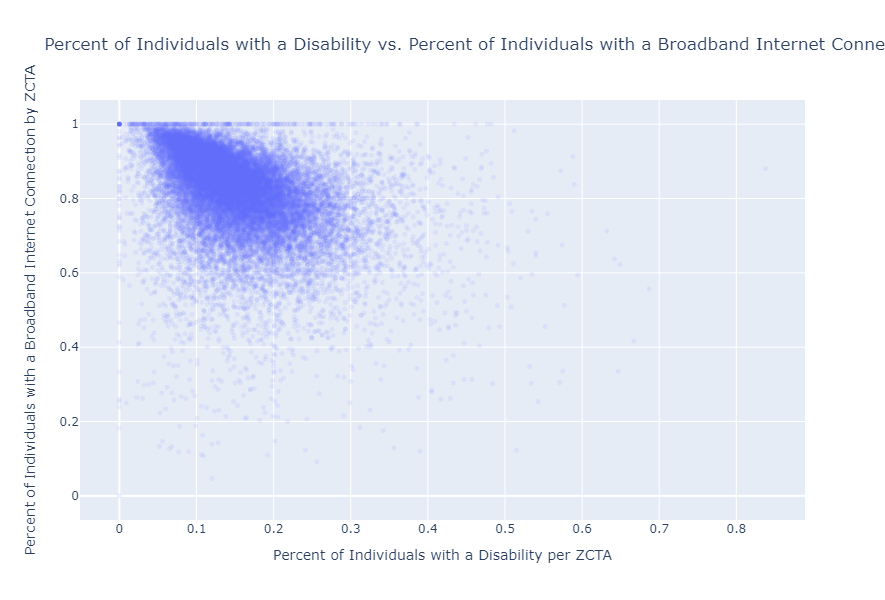

In [158]:
test_fig = px.scatter(independent_design_matrix,
        x="Estimate Disability Status Of The Civilian Noninstitutionalized Population Total Civilian Noninstitutionalized Population With A Disability As a Percent of Estimate Disability Status Of The Civilian Noninstitutionalized Population Total Civilian Noninstitutionalized Population",
        y="Estimate Computers And Internet Use Total Households With A Broadband Internet Subscription As a Percent of Estimate Computers And Internet Use Total Households",
        title="Percent of Individuals with a Disability vs. Percent of Individuals with a Broadband Internet Connection by ZCTA",
       )

test_fig.update_traces(marker=dict(size=5, opacity=0.1))
test_fig.update_layout(height=600)
test_fig.update_xaxes(title_text="Percent of Individuals with a Disability per ZCTA")
test_fig.update_yaxes(title_text="Percent of Individuals with a Broadband Internet Connection by ZCTA")
test_fig.show()

<h2>Cleaning PLACES Data</h2>

In [2]:
import pandas as pd
import numpy as np

places_data = pd.read_csv('./PLACES__Local_Data_for_Better_Health__ZCTA_Data_2023_release.csv')
places_data

C:\Users\na933\AppData\Local\Temp\ipykernel_15472\20768884.py:4: DtypeWarning: Columns (8,9) have mixed types. Specify dtype option on import or set low_memory=False.
  places_data = pd.read_csv('./PLACES__Local_Data_for_Better_Health__ZCTA_Data_2023_release.csv')


,Year,LocationName,DataSource,Category,Measure,Data_Value_Unit,Data_Value_Type,Data_Value,Data_Value_Footnote_Symbol,Data_Value_Footnote,Low_Confidence_Limit,High_Confidence_Limit,TotalPopulation,Geolocation,LocationID,CategoryID,MeasureId,DataValueTypeID,Short_Question_Text
0,2021,1001,BRFSS,Prevention,Current lack of health insurance among adults ...,%,Crude prevalence,4.1,NaN,NaN,3.4,5.0,16769,POINT (-72.62581515 42.06255509),1001,PREVENT,ACCESS2,CrdPrv,Health Insurance
1,2021,1001,BRFSS,Health Outcomes,Arthritis among adults aged >=18 years,%,Crude prevalence,33.7,NaN,NaN,30.1,37.4,16769,POINT (-72.62581515 42.06255509),1001,HLTHOUT,ARTHRITIS,CrdPrv,Arthritis
2,2021,1001,BRFSS,Health Risk Behaviors,Binge drinking among adults aged >=18 years,%,Crude prevalence,15.6,NaN,NaN,13.2,18.2,16769,POINT (-72.62581515 42.06255509),1001,RISKBEH,BINGE,CrdPrv,Binge Drinking
3,2021,1001,BRFSS,Health Outcomes,High blood pressure among adults aged >=18 years,%,Crude prevalence,33.8,NaN,NaN,30.2,37.4,16769,POINT (-72.62581515 42.06255509),1001,HLTHOUT,BPHIGH,CrdPrv,High Blood Pressure
4,2021,1001,BRFSS,Prevention,Taking medicine for high blood pressure contro...,%,Crude prevalence,78.9,NaN,NaN,75.7,81.8,16769,POINT (-72.62581515 42.06255509),1001,PREVENT,BPMED,CrdPrv,Taking BP Medication
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1169987,2021,99929,BRFSS,Disability,Self-care disability among adults aged >=18 years,%,Crude prevalence,4.2,NaN,NaN,3.6,5.1,2338,POINT (-131.6992663 56.36477625),99929,DISABLT,SELFCARE,CrdPrv,Self-care Disability
1169988,2020,99929,BRFSS,Health Risk Behaviors,Sleeping less than 7 hours among adults aged >...,%,Crude prevalence,30.3,NaN,NaN,28.9,31.6,2338,POINT (-131.6992663 56.36477625),99929,RISKBEH,SLEEP,CrdPrv,Sleep <7 hours
1169989,2021,99929,BRFSS,Health Outcomes,Stroke among adults aged >=18 years,%,Crude prevalence,3.7,NaN,NaN,3.3,4.2,2338,POINT (-131.6992663 56.36477625),99929,HLTHOUT,STROKE,CrdPrv,Stroke
1169990,2020,99929,BRFSS,Health Outcomes,All teeth lost among adults aged >=65 years,%,Crude prevalence,15.7,NaN,NaN,11.3,20.6,2338,POINT (-131.6992663 56.36477625),99929,HLTHOUT,TEETHLOST,CrdPrv,All Teeth Lost


In [3]:
selected_features = ['Diagnosed diabetes among adults aged >=18 years',
                     'Mental health not good for >=14 days among adults aged >=18 years',
                     'Stroke among adults aged >=18 years']
places_data_filtered = places_data[places_data["Measure"].isin(selected_features)]
places_data_filtered

,Year,LocationName,DataSource,Category,Measure,Data_Value_Unit,Data_Value_Type,Data_Value,Data_Value_Footnote_Symbol,Data_Value_Footnote,Low_Confidence_Limit,High_Confidence_Limit,TotalPopulation,Geolocation,LocationID,CategoryID,MeasureId,DataValueTypeID,Short_Question_Text
19,2021,1001,BRFSS,Health Outcomes,Diagnosed diabetes among adults aged >=18 years,%,Crude prevalence,10.1,NaN,NaN,8.7,11.7,16769,POINT (-72.62581515 42.06255509),1001,HLTHOUT,DIABETES,CrdPrv,Diabetes
28,2021,1001,BRFSS,Health Status,Mental health not good for >=14 days among adu...,%,Crude prevalence,16.3,NaN,NaN,14.4,18.3,16769,POINT (-72.62581515 42.06255509),1001,HLTHSTAT,MHLTH,CrdPrv,Mental Health
34,2021,1001,BRFSS,Health Outcomes,Stroke among adults aged >=18 years,%,Crude prevalence,3.3,NaN,NaN,3.0,3.7,16769,POINT (-72.62581515 42.06255509),1001,HLTHOUT,STROKE,CrdPrv,Stroke
56,2021,1002,BRFSS,Health Outcomes,Diagnosed diabetes among adults aged >=18 years,%,Crude prevalence,6.8,NaN,NaN,5.8,7.9,29049,POINT (-72.4509085 42.38758794),1002,HLTHOUT,DIABETES,CrdPrv,Diabetes
65,2021,1002,BRFSS,Health Status,Mental health not good for >=14 days among adu...,%,Crude prevalence,20.2,NaN,NaN,17.7,22.8,29049,POINT (-72.4509085 42.38758794),1002,HLTHSTAT,MHLTH,CrdPrv,Mental Health
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1169947,2021,99927,BRFSS,Health Status,Mental health not good for >=14 days among adu...,%,Crude prevalence,15.7,NaN,NaN,13.5,17.8,94,POINT (-133.511342 56.26385195),99927,HLTHSTAT,MHLTH,CrdPrv,Mental Health
1169953,2021,99927,BRFSS,Health Outcomes,Stroke among adults aged >=18 years,%,Crude prevalence,4.0,NaN,NaN,3.5,4.5,94,POINT (-133.511342 56.26385195),99927,HLTHOUT,STROKE,CrdPrv,Stroke
1169974,2021,99929,BRFSS,Health Outcomes,Diagnosed diabetes among adults aged >=18 years,%,Crude prevalence,10.9,NaN,NaN,9.3,12.9,2338,POINT (-131.6992663 56.36477625),99929,HLTHOUT,DIABETES,CrdPrv,Diabetes
1169983,2021,99929,BRFSS,Health Status,Mental health not good for >=14 days among adu...,%,Crude prevalence,15.3,NaN,NaN,13.2,17.9,2338,POINT (-131.6992663 56.36477625),99929,HLTHSTAT,MHLTH,CrdPrv,Mental Health


In [6]:
def clean_zcta(zcta):
    if len(str(zcta)) == 5:
        return str(zcta)
    return "0" + str(zcta)
places_data_filtered["ZCTA"] = places_data_filtered["LocationName"].map(clean_zcta)
places_data_filtered

C:\Users\na933\AppData\Local\Temp\ipykernel_15472\1738225527.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  places_data_filtered["ZCTA"] = places_data_filtered["LocationName"].map(clean_zcta)


,Year,LocationName,DataSource,Category,Measure,Data_Value_Unit,Data_Value_Type,Data_Value,Data_Value_Footnote_Symbol,Data_Value_Footnote,Low_Confidence_Limit,High_Confidence_Limit,TotalPopulation,Geolocation,LocationID,CategoryID,MeasureId,DataValueTypeID,Short_Question_Text,ZCTA
19,2021,1001,BRFSS,Health Outcomes,Diagnosed diabetes among adults aged >=18 years,%,Crude prevalence,10.1,NaN,NaN,8.7,11.7,16769,POINT (-72.62581515 42.06255509),1001,HLTHOUT,DIABETES,CrdPrv,Diabetes,01001
28,2021,1001,BRFSS,Health Status,Mental health not good for >=14 days among adu...,%,Crude prevalence,16.3,NaN,NaN,14.4,18.3,16769,POINT (-72.62581515 42.06255509),1001,HLTHSTAT,MHLTH,CrdPrv,Mental Health,01001
34,2021,1001,BRFSS,Health Outcomes,Stroke among adults aged >=18 years,%,Crude prevalence,3.3,NaN,NaN,3.0,3.7,16769,POINT (-72.62581515 42.06255509),1001,HLTHOUT,STROKE,CrdPrv,Stroke,01001
56,2021,1002,BRFSS,Health Outcomes,Diagnosed diabetes among adults aged >=18 years,%,Crude prevalence,6.8,NaN,NaN,5.8,7.9,29049,POINT (-72.4509085 42.38758794),1002,HLTHOUT,DIABETES,CrdPrv,Diabetes,01002
65,2021,1002,BRFSS,Health Status,Mental health not good for >=14 days among adu...,%,Crude prevalence,20.2,NaN,NaN,17.7,22.8,29049,POINT (-72.4509085 42.38758794),1002,HLTHSTAT,MHLTH,CrdPrv,Mental Health,01002
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1169947,2021,99927,BRFSS,Health Status,Mental health not good for >=14 days among adu...,%,Crude prevalence,15.7,NaN,NaN,13.5,17.8,94,POINT (-133.511342 56.26385195),99927,HLTHSTAT,MHLTH,CrdPrv,Mental Health,99927
1169953,2021,99927,BRFSS,Health Outcomes,Stroke among adults aged >=18 years,%,Crude prevalence,4.0,NaN,NaN,3.5,4.5,94,POINT (-133.511342 56.26385195),99927,HLTHOUT,STROKE,CrdPrv,Stroke,99927
1169974,2021,99929,BRFSS,Health Outcomes,Diagnosed diabetes among adults aged >=18 years,%,Crude prevalence,10.9,NaN,NaN,9.3,12.9,2338,POINT (-131.6992663 56.36477625),99929,HLTHOUT,DIABETES,CrdPrv,Diabetes,99929
1169983,2021,99929,BRFSS,Health Status,Mental health not good for >=14 days among adu...,%,Crude prevalence,15.3,NaN,NaN,13.2,17.9,2338,POINT (-131.6992663 56.36477625),99929,HLTHSTAT,MHLTH,CrdPrv,Mental Health,99929


In [7]:
places_data_filtered.set_index("ZCTA", inplace=True)
places_data_filtered["Percent"] = places_data_filtered["Data_Value"] / 100
places_data_cleaned = places_data_filtered[["Measure", "Percent"]]
places_data_cleaned

C:\Users\na933\AppData\Local\Temp\ipykernel_15472\3531710634.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  places_data_filtered["Percent"] = places_data_filtered["Data_Value"] / 100


,Measure,Percent
ZCTA,,
01001,Diagnosed diabetes among adults aged >=18 years,0.101
01001,Mental health not good for >=14 days among adu...,0.163
01001,Stroke among adults aged >=18 years,0.033
01002,Diagnosed diabetes among adults aged >=18 years,0.068
01002,Mental health not good for >=14 days among adu...,0.202
...,...,...
99927,Mental health not good for >=14 days among adu...,0.157
99927,Stroke among adults aged >=18 years,0.040
99929,Diagnosed diabetes among adults aged >=18 years,0.109


In [10]:
outcome_matrix = places_data_cleaned.pivot(columns="Measure", values="Percent")
outcome_matrix

Measure,Diagnosed diabetes among adults aged >=18 years,Mental health not good for >=14 days among adults aged >=18 years,Stroke among adults aged >=18 years
ZCTA,,,
01001,0.101,0.163,0.033
01002,0.068,0.202,0.021
01003,0.020,0.338,0.007
01005,0.083,0.162,0.027
01007,0.071,0.147,0.023
...,...,...,...
99923,0.090,0.115,0.031
99925,0.127,0.170,0.042
99926,0.138,0.198,0.044
